<a href="https://colab.research.google.com/github/AudreyNessa/Housing-Prices/blob/main/housing_prices_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [ ]:
#Import more libraries
from category_encoders import MEstimateEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Clean Data and Engineer Features

In [ ]:
X_train_full = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv", index_col="Id")
X_test_full = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv", index_col="Id")

#make deep copies of the data so that our manipulations won't affect the original data
X_train = X_train_full.copy()
X_test = X_test_full.copy()

#remove rows with missing targets, separate target from features
X_train.dropna(axis=0, subset=["SalePrice"], inplace=True)
y_train = X_train.pop("SalePrice")
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**Drop Columns with Excess Null Values**

In [ ]:
#find the columns that have null values
null_columns_train = X_train.columns[X_train.isnull().any()]
null_columns_test = X_test.columns[X_test.isnull().any()]
null_columns = list(set(null_columns_train.append(null_columns_test)))

print(f"X_train sum of missing values \n {X_train[null_columns_train].isnull().sum()}")
print(f"\nX_test sum of missing values\n {X_test[null_columns_test].isnull().sum()}")

#Drop any feature that has more than the threshold number of missing values
THRESHOLD = 500
cols_to_drop = [cname for cname in null_columns if
    (X_train[cname].isnull().sum() > THRESHOLD) |
    (X_test[cname].isnull().sum() > THRESHOLD)
]
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

X_train sum of missing values 
 LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

X_test sum of missing values
 MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78


**Some functions' definitions**

In [ ]:
def fill_missing_values(X):
    """
    Returns a dataset with its missing values filled using SimpleImputer()
    
    Parametres
    X: the dataset
    """
    X = X.copy()
     
    #fill missing values and change to the dataset back to a dataframe
    columns = X.columns
    imputer = SimpleImputer(strategy="most_frequent")
    X = imputer.fit_transform(X)
    X = pd.DataFrame(X, columns=columns)
    
    return X

def fill_and_encode_dataset(X):
    """
    Returns the dataset with its missing values filled and its
    categorical columns encoded as enumerated types
    
    Parameters:
    X: the dataset to be filled and encoded
    """
    X = X.copy()
    X = fill_missing_values(X)
    
    #encode the categorical columns as enumerated types
    for cname in X.select_dtypes(["object", "category"]):
        X[cname], _ = X[cname].factorize()
    
    return X
    
def make_mi_scores(X, y):
    """
    Returns the mutual information scores of the features when compared to the target
    
    Parametres
    X: the data containing the features
    y: the data containing the targets
    """
    X = X.copy()
    X = fill_and_encode_dataset(X)
    
    #separate the discrete features from the continuous features and find the mutual information
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def apply_pca(X, standardize=True):
    """
    Returns pca(), the principal component analysis of the features, and their loadings
    
    Parametres:
    X: the data containing the features
    standardize: indicates if the user wants the data to be standardized before applying pca
    """
    X = X.copy()
    X = fill_missing_values(X)
    
    #standardize the data using the z-score normalization if requested
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    #create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    #convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    
    #create loadings
    loadings = pd.DataFrame(
        pca.components_.T, #transpose the matrix of loadings
        columns=component_names, # so the columns are the principal components
        index=X.columns # and the rows are the original features
    )
    
    return pca, X_pca, loadings

def apply_kmeans(X, n_clusters=10):
    """
    Returns kmeans and a pandas series of the cluster categories of a dataset
    
    Parametres:
    X: the data to be categorised into clusters
    n_cluster: the number of clusters the dataset should have
    """
    X = X.copy()
    X = fill_and_encode_dataset(X)
    
    kmeans = KMeans(n_clusters=n_clusters)
    X = pd.Series(kmeans.fit_predict(X))
    
    return kmeans, X

def score_dataset(X, y, model=XGBRegressor()):
    """
    Returns the mean value of the mean-squarred error after running a 5 CV on a model
    
    Parametres:
    pipeline: a pipeline containing the preprocessor and the model to use to run the test
    X: the data containing the features
    y: the data containing the targets
    """
    X = X.copy()
    X = fill_and_encode_dataset(X)
    
    #score the dataset 
    cv_scores = -1 * cross_val_score(model, X, y,
                                     cv=5,
                                     scoring="neg_mean_absolute_error"
                )

    return cv_scores.mean()

def drop_outliers(X_pca, X_train, y_train, pc, n_outliers, ascending=True):
    """
    Drops the outliers in the dataset
    
    Parametres:
    X_pca: the dataset containing the principal component analysis
    X_train: the dataset containing the features
    y_train: the dataset containing the targets
    pc: principal component column name
    n_outliers: the number of outliers to drop
    ascending: determines if the dataset should be sorted in ascending or descending order
    """
    idx = X_pca[pc].sort_values(ascending=ascending).index
    
    print(X_train.iloc[idx].head(15))
    
    X_train.drop(idx[: n_outliers], axis=0, inplace=True)
    y_train.drop(idx[: n_outliers], axis=0, inplace=True)
   
    

**Drop Columns with Low Mutual Information**

In [ ]:
mi_scores = make_mi_scores(X_train, y_train)
print(f"The mutual information scores are {mi_scores}")

#store the columns with low mutual information in a list
MI_LOW_THRESHOLD = 0.1
low_mi_columns = [cname for cname in mi_scores.index if mi_scores[cname] < MI_LOW_THRESHOLD]
print(f"\nThe columns with low mi_scores are \n{low_mi_columns}")

#drop the columns with low mi_scores
X_train.drop(low_mi_columns, axis=1, inplace=True)
X_test.drop(low_mi_columns, axis=1, inplace=True)

The mutual information scores are OverallQual     5.714348e-01
Neighborhood    5.272377e-01
GarageArea      4.999292e-01
GrLivArea       4.325040e-01
YearBuilt       4.097242e-01
                    ...     
MiscVal         6.266163e-05
Utilities       1.887379e-15
PoolArea        2.220446e-16
MoSold          0.000000e+00
LandSlope       0.000000e+00
Name: MI Scores, Length: 74, dtype: float64

The columns with low mi_scores are 
['LotShape', 'SaleCondition', 'SaleType', 'HalfBath', 'HouseStyle', 'BedroomAbvGr', 'CentralAir', 'BsmtExposure', 'Electrical', 'PavedDrive', 'BldgType', 'BsmtCond', 'LandContour', 'KitchenAbvGr', 'BsmtFullBath', 'EnclosedPorch', 'ScreenPorch', 'Condition1', 'GarageCond', 'RoofStyle', 'Heating', 'ExterCond', 'LotConfig', 'GarageQual', 'BsmtFinType2', 'BsmtHalfBath', 'LowQualFinSF', 'RoofMatl', 'Functional', 'YrSold', 'BsmtFinSF2', '3SsnPorch', 'Condition2', 'Street', 'MiscVal', 'Utilities', 'PoolArea', 'MoSold', 'LandSlope']


**Find and Add New Features**

In [ ]:
#separate the numerical columns from the categorical columns
numeric_cols = [cname for cname in X_train.columns 
                if (X_train[cname].dtype in ["int64", "float64"])
               ]
cat_cols = [cname for cname in X_train.columns if cname not in numeric_cols]

#get columns with numeric values that have high mutual information
high_mi_num_columns = [cname for cname in mi_scores.index 
                       if cname in numeric_cols
                      ]

#get mi_scores, the principal component analysis, and loadings of the top 6 features
pca, X_pca, loadings = apply_pca(X_train.loc[:, high_mi_num_columns[:6]])
mi_scores = make_mi_scores(X_pca, y_train)

#print out the loadings of the principal components with high mi_scores
print(f"\nThe mi_scores for the principal components are \n{mi_scores}")
print(f"The loadings are\n{loadings}")

X_train.loc[:, high_mi_num_columns[:6]]


The mi_scores for the principal components are 
PC1    0.988826
PC2    0.124769
PC4    0.086230
PC3    0.069821
PC6    0.058912
PC5    0.050970
Name: MI Scores, dtype: float64
The loadings are
                  PC1       PC2       PC3       PC4       PC5       PC6
OverallQual  0.493289 -0.183495 -0.182397 -0.074021 -0.394773 -0.726913
GarageArea   0.455438 -0.080789  0.059429 -0.382955  0.793638 -0.077468
GrLivArea    0.418554  0.271010 -0.652737 -0.174868 -0.198794  0.505176
YearBuilt    0.382226 -0.477318  0.536761 -0.155428 -0.339644  0.445469
TotalBsmtSF  0.440664  0.110226  0.092673  0.866080  0.175598  0.064403
LotArea      0.183774  0.803974  0.490340 -0.207449 -0.169060 -0.088336


,OverallQual,GarageArea,GrLivArea,YearBuilt,TotalBsmtSF,LotArea
Id,,,,,,
1,7,548,1710,2003,856,8450
2,6,460,1262,1976,1262,9600
3,7,608,1786,2001,920,11250
4,7,642,1717,1915,756,9550
5,8,836,2198,2000,1145,14260
...,...,...,...,...,...,...
1456,6,460,1647,1999,953,7917
1457,6,500,2073,1978,1542,13175
1458,7,252,2340,1941,1152,9042


In [ ]:
#make new features using the information derived from pca
X_train["Feature1"] = (X_train.LotArea + X_train.GrLivArea) * X_train.YearBuilt
X_test["Feature1"] = (X_test.LotArea + X_test.GrLivArea) * X_test.YearBuilt

#add a cluster feature
kmeans, X_train["Cluster"] = apply_kmeans(X_train, n_clusters=5)
X_test["Cluster"] = kmeans.predict(fill_and_encode_dataset(X_test))
X_train["Cluster"] = X_train["Cluster"].astype("category")
X_test["Cluster"] = X_test["Cluster"].astype("category")

#update numeric columns and categorical columns
numeric_cols = numeric_cols + ["Feature1"]
cat_cols = cat_cols + ["Cluster"]

**Remove Outliers**

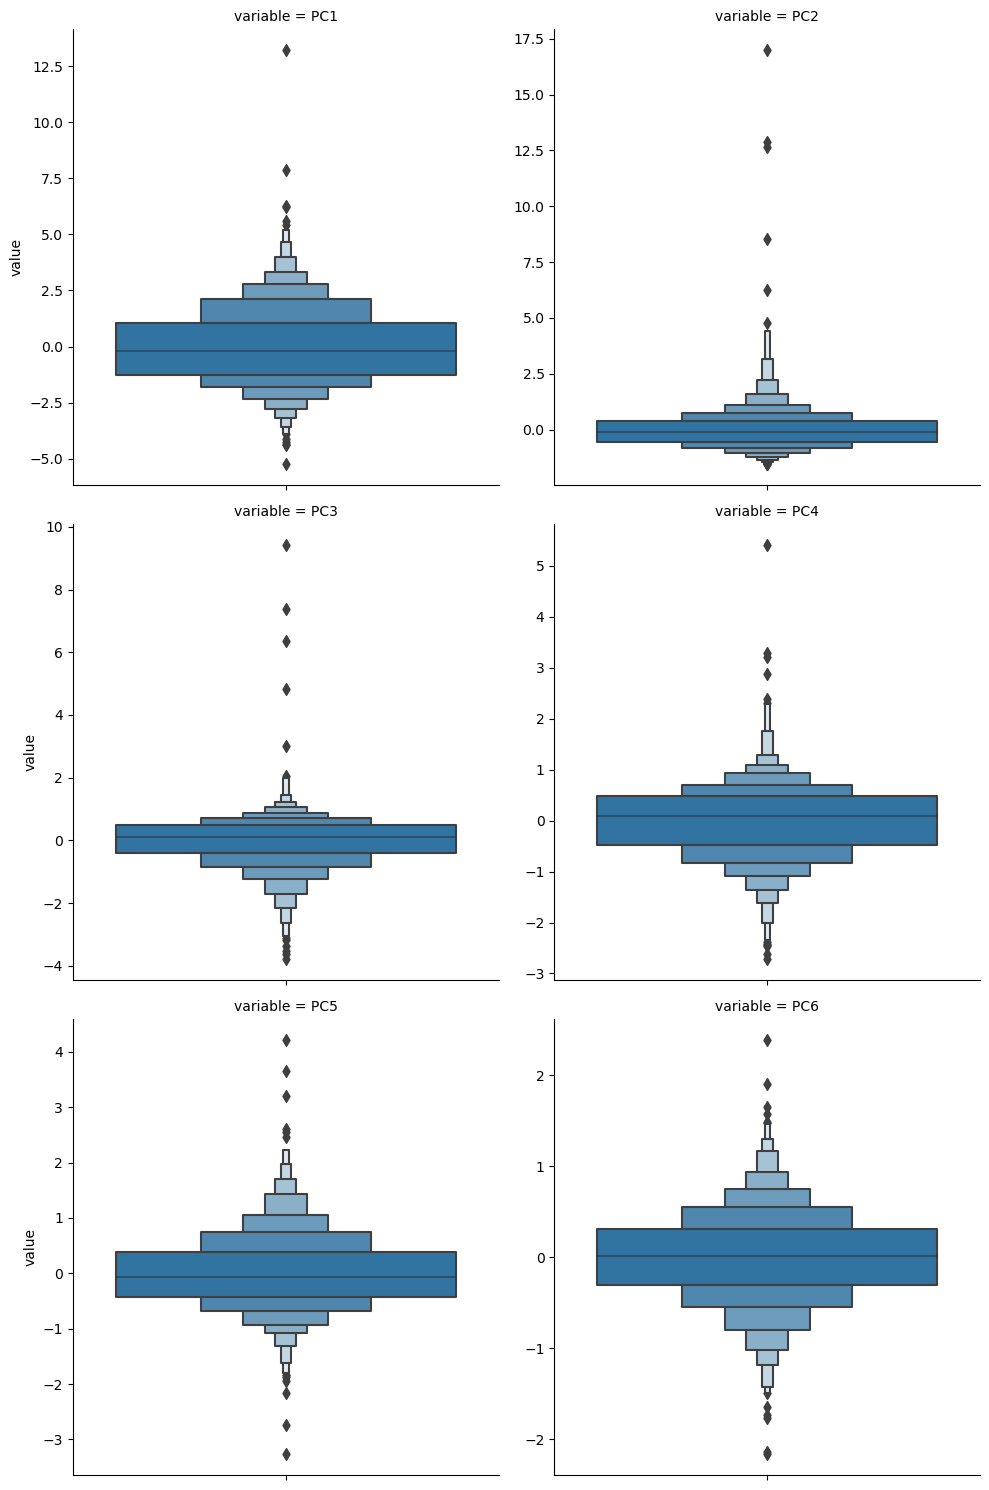

In [ ]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [ ]:
drop_outliers(X_pca, X_train, y_train, "PC2", n_outliers=5, ascending=False)

      MSSubClass MSZoning  LotFrontage  LotArea Neighborhood  OverallQual  \
Id                                                                          
314           20       RL        150.0   215245       Timber            7   
336          190       RL          NaN   164660       Timber            5   
250           50       RL          NaN   159000      ClearCr            6   
707           20       RL          NaN   115149      ClearCr            7   
1299          60       RL        313.0    63887      Edwards           10   
452           20       RL         62.0    70761      ClearCr            7   
849           50       RL         75.0    45600      ClearCr            6   
1397          20       RL          NaN    57200       Timber            5   
458           20       RL          NaN    53227      ClearCr            4   
770           60       RL         47.0    53504      StoneBr            8   
385           60       RL          NaN    53107      ClearCr            6   

# Preprocess the Data

In [ ]:
#temporarily fill the categorical columns in the test set
imputer = SimpleImputer(strategy="most_frequent")
X_test_temp = pd.DataFrame(imputer.fit_transform(X_test[cat_cols]))
X_test_temp.columns = cat_cols

#check if there're any values in cat_cols in the test set that are different from the training set
cols_to_drop = [cname for cname in cat_cols if
    np.isin(X_test_temp[cname].unique(), X_train[cname].unique(), assume_unique=True, invert=True).any()
]   

cols_to_drop

[]

In [ ]:
#preprocessing for numerical data
numeric_int_cols = [cname for cname in numeric_cols if X_train[cname].dtype == "int64" ]
numeric_decimal_cols = [cname for cname in numeric_cols if X_train[cname].dtype == "float64"]

numeric_transformer_int = SimpleImputer(strategy="most_frequent")
numeric_transformer_float = SimpleImputer(strategy="mean")

#separate the columns with many categories from those with few
cat_few_unique_values = [cname for cname in cat_cols if X_train[cname].nunique() < 10]
cat_many_unique_values = [cname for cname in cat_cols if cname not in cat_few_unique_values]

#print the frequency of the categories of the columns with many unique values
for cname in cat_many_unique_values:
    print(f"The frequency of the categories for {cname} is\n{X_train[cname].value_counts()}\n")

The frequency of the categories for Neighborhood is
NAmes      225
CollgCr    149
OldTown    112
Edwards     99
Somerst     86
Gilbert     78
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      36
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

The frequency of the categories for Exterior1st is
VinylSd    511
HdBoard    222
MetalSd    219
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

The frequency of the categories for Exterior2nd is
VinylSd    501
MetalSd    213
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     37
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7

In [ ]:
#preprossessing or categorical data
cat_transformer_many = Pipeline(steps=[
        ('Imputer', SimpleImputer(strategy="most_frequent")),
        ('Ordinal', MEstimateEncoder(m=30)),
    ]
)

cat_transformer_few = Pipeline(steps=[
        ('Imputer', SimpleImputer(strategy="most_frequent")),
        ('OneHot', OneHotEncoder(handle_unknown="ignore", sparse="False"))
    ]
)


In [ ]:
#Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('numint', numeric_transformer_int, numeric_int_cols),
        ('numfloat', numeric_transformer_float, numeric_decimal_cols),
        ('catmany', cat_transformer_many, cat_many_unique_values),
        ('catfew', cat_transformer_few, cat_few_unique_values)
    ]
)


# Set Hyperparametres

In [ ]:
def get_best_value(scores_list, values_list):
    """
    Returns the value with the lowest mean-absolute error and plots the graph of all values
    
    Parametres:
    scores_list: a list of the mean of the mean-absolute errors after running cross validation
    values_list: a list of the values used to tune the hyperparamtres
    """
    
    best_score_index = scores_list.index(min(scores_list))
    best_value = values_list[best_score_index]
    print("The best value is ", best_value)

    plt.plot(values_list, scores_list)
    plt.show()
    
    return best_value

In [ ]:
#split the training data set
X_cv_full, X_t, y_cv_full, y_t = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)
model = XGBRegressor()

The best value is  13


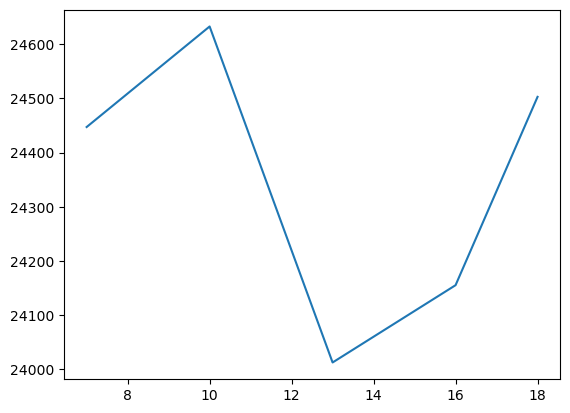

In [ ]:
#get the best min_child_weight
min_child_weights = [7, 10, 13, 16, 18]
min_child_weights_scores = []


for i in range(len(min_child_weights)):
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,
        random_state=0,
        reg_lambda=150,
        min_child_weight=min_child_weights[i]
    )

    min_child_weights_scores.append(score_dataset(X_cv_full, y_cv_full, model))
    
#choose the best min_child_weight and plot the graph
best_child_weight = get_best_value(min_child_weights_scores, min_child_weights)


The best value is  0.3


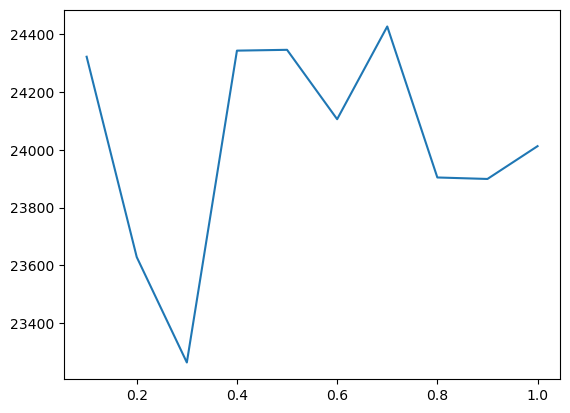

In [ ]:
#get the best colsample_bytree
colsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
colsamples_scores = []

for i in range(len(colsamples)):
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300, 
        random_state=0,
        reg_lambda=150,
        min_child_weight=best_child_weight,
        colsample_bytree = colsamples[i]
    )
    
    colsamples_scores.append(score_dataset(X_cv_full, y_cv_full, model))
    
#choose the best colsample and plot the graph
best_colsample = get_best_value(colsamples_scores, colsamples)

The best value is  6


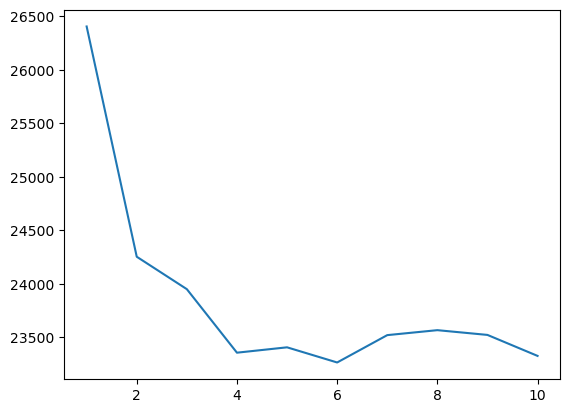

In [ ]:
#get the best max_depth
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depths_scores = []

for i in range(len(max_depths)):
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300, 
        random_state=0,
        reg_lambda=150,
        min_child_weight=best_child_weight,
        colsample_bytree=best_colsample,
        max_depth=max_depths[i]
    )
    
    max_depths_scores.append(score_dataset(X_cv_full, y_cv_full, model))
    
#choose the best max depth and plot the graph
best_max_depth = get_best_value(max_depths_scores, max_depths)


# Create the Final Model

In [ ]:
#take a fraction of the cross-validation set to target encode
X_cv1, _, y_cv1, _ = train_test_split(X_cv_full, y_cv_full, train_size=0.8, shuffle=True, random_state=0)

#create a model with the hyperparametres and predict housing prices
model = XGBRegressor(
objective="reg:squarederror",
n_estimators=1000, 
early_stopping_rounds=5, 
learning_rate=0.05,
reg_lambda=150,
max_depth=best_max_depth,
colsample_bytree=best_colsample,
min_child_weight=best_child_weight,
random_state=0 
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

#transform the data
X_cv1 = pipeline.fit_transform(X_cv1, y_cv1)
X_cv_full = pipeline.transform(X_cv_full)
X_t = pipeline.transform(X_t)

model.fit(
    X_cv_full, y_cv_full, 
    eval_set=[(X_t, y_t)],
    verbose=True
)



[0]	validation_0-rmse:188254.44775
[1]	validation_0-rmse:181292.74861
[2]	validation_0-rmse:174641.26981
[3]	validation_0-rmse:168348.96968
[4]	validation_0-rmse:162475.80144
[5]	validation_0-rmse:156802.95669
[6]	validation_0-rmse:151488.57210
[7]	validation_0-rmse:146382.14721
[8]	validation_0-rmse:141494.18779
[9]	validation_0-rmse:136819.73235
[10]	validation_0-rmse:132431.39125
[11]	validation_0-rmse:128317.37717
[12]	validation_0-rmse:124322.77780
[13]	validation_0-rmse:120640.45975
[14]	validation_0-rmse:117036.62272
[15]	validation_0-rmse:113632.68814
[16]	validation_0-rmse:110424.32742
[17]	validation_0-rmse:107399.43550
[18]	validation_0-rmse:104487.64124
[19]	validation_0-rmse:101741.22575
[20]	validation_0-rmse:99121.98301
[21]	validation_0-rmse:96575.20402
[22]	validation_0-rmse:94185.12101
[23]	validation_0-rmse:91744.79126
[24]	validation_0-rmse:89360.90463
[25]	validation_0-rmse:87159.79535
[26]	validation_0-rmse:85127.82624
[27]	validation_0-rmse:83241.38615
[28]	valid

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=13,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=150, ...)

In [ ]:
#generate test prediction
X_test = pipeline.transform(X_test)
test_prediction = model.predict(X_test)

#save prediction in format used for prediction scoring
output = pd.DataFrame({
    "Id" : X_test_full.index,
    "SalePrice" : test_prediction
})
output.to_csv("submission.csv", index=False)